<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/3.%20Frameworks%20Software/Practica3.6.%20Keras%3A%20regresi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRÁCTICA 3.4. REGRESIÓN Y K-VALIDACIÓN

En las prácticas anteriores hemos trabajado con clasificación, tanto multiclase como binaria. Ahora veremos un ejemplo de cómo hacer regresión, intentando predecir un valor continuo en vez de una etiqueta discreta.


In [1]:
# Imports y configuración
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

## 0. Objetivos
* Crear un modelo para regresión: arquitectura modelo y función de pérdida.
* Uso de OpenML para la descarga del dataset.
* Manejo de un dataset pequeño mediante K-validación cruzada.

## 1. El Dataset de Precios de Casas de Boston

Intentaremos predecir el precio medio de **casas de un barrio de Boston** (a partir de datos de los años 70). Para ello, usaremos algo de información asociada a algunas de las casas de ese barrio: tasa de crimen, impuestos locales, etc.

A diferencia de los datasets vistos en los ejemplos anteriores, éste es realmente pequeño, apenas 506 anotaciones, que están divididas en 404/102 en entrenamiento/test. Además, cada una de las características de los datos de entrada usa una escala diferente, por ejemlo, algunos valores son proporciones (continuos en $[0,1]$), otros toman valores discretos entre 1 y 12, otros entre 0 y 100, etc.

Podemos echar un vistazo a los datos. Para ello vamos a usar la plataforma *OpenML*, la cual es una colaboración en machine learning que permite a los investigadores y científicos de datos compartir y acceder a datasets, algoritmos y resultados de experimentos de forma abierta. La función `fetch_openml` de `scikit-learn` es una interfaz que te permite descargar datasets directamente desde esta plataforma. Como la plataforma OpenML puede estar en mantemiento, o que el dataset se mueva por cuestiones éticas (incluye una características sobre *composición racial*), vamos a poner una opción de respaldo de descarga directa del dataset original.

In [2]:
# Carga del dataset Boston Housing
# Intentamos varias opciones para mayor robustez:
# 1) sklearn.datasets.fetch_openml('boston', version=1)
# 2) si no está disponible, descargamos desde la UCI repository

def load_boston_dataset():
    try:
        from sklearn.datasets import fetch_openml
        data = fetch_openml(name='boston', version=1, as_frame=True, parser='auto')        
        X = data.data.values.astype('float32') # obtenemos el numpy array de las X
        y = data.target.values.astype('float32') # numpy array de Y
        print('Cargado Boston desde fetch_openml (sklearn).')
        return X, y, data.frame
    except Exception as e:
        print('Falló fetch_openml:', e)
        try:  # Si falla openml, podemos ir directo a los datos originales
            url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
            col_names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
            df = pd.read_csv(url, header=None, sep='\s+', names=col_names)
            X = df.iloc[:, :-1].values.astype('float32')
            y = df['MEDV'].values.astype('float32')
            print('Cargado Boston desde UCI repository (pandas).')
            return X, y, df
        except Exception as e2:
            raise RuntimeError('No se pudo descargar el dataset Boston automáticamente. Por favor descarga los datos manualmente y cárgalos en X, y.') from e2

X, y, data = load_boston_dataset()

print(data.head())

print('\nX shape:', X.shape, 'y shape:', y.shape)




Cargado Boston desde fetch_openml (sklearn).
      CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  PTRATIO  \
0  0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0     15.3   
1  0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0     17.8   
2  0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0     17.8   
3  0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0     18.7   
4  0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  

X shape: (506, 13) y shape: (506,)



Como se puede observar, cada dato tiene 13 características, que esperamos permitan obtener una relación funcional para predecir su precio, como por ejemplo:

1. Ratio de crimen per cápita.
2. Proporción de área residencial en lotes de 25.000 pies cuadrado.
3. ...

El objetivo es el valor medio de las casas, en miles de dólares:

In [3]:
print(y[:20]) # veamos los 20 primeros
print('Mínimo: ', y.min())
print('Máximo: ', y.max())

[24.  21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 15.  18.9 21.7 20.4
 18.2 19.9 23.1 17.5 20.2 18.2]
Mínimo:  5.0
Máximo:  50.0



Los precios están, aproximadamente, entre 5.000\$ y 50.000\$ (precios de los años 70, claro). Vamos también a dividir el dataset en train 80% y en test 20%, forzando el random_state para reproducibilidad.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape)

Train/Test shapes: (404, 13) (102, 13)


## 2. Preparando los datos

Sería problemático alimentar la red neuronal con los datos en bruto que proporciona el dataset, que hace uso de rangos tan diferentes para cada característica. Si fuera así, la red debería aprender, además de la relación funcional, a adaptar automáticamente la heterogeneidad de los datos, lo que haría que el aprendizaje fuera más complicado. Como vimos en la práctica anterior, una buena práctica de preprocesamiento consiste en hacer una estandarización de cada característica: para cada una de ellas (una columna) se extrae la media de sus valores y se divide por su desviación estándar, de esta forma la nueva características estará centrada en 0 y con desviación estándar 1:

In [5]:
# calculamos la media del conjunto de train
mean = X_train.mean(axis=0)
X_train -= mean
# calculamos la desviación estándar del conjunto de train
std = X_train.std(axis=0)
X_train /= std

Esto equivale a usar `StandardScaler` de scikit-learn, como hicimos en la práctica anterior, donde aplicamos la estandarización a todo el dataset antes de dividirlo.

Sin embargo, al estandarizar el dataset de entrenamiento, el modelo se ajustará para datos cuyos valores se les haya sustraído la media y la desviación del conjunto de entrenamiento. Por tanto, todo dato que después se le pase al modelo para hacer una predicción, debería también ser transformado de la misma manera. Para ilustrarlo, vamos a normalizar el conjunto de test con la media y desviación del conjunto de entrenamiento. Recuerda esta técnica, ya que más adelante tendremos que usarla con modelos convolucionales pre-entrenados.

In [6]:
# normalizamos el conjunto de test con la media y std del conjunto de train
X_test -= mean
X_test /= std

## 3. Construyendo la red

Debido a que hay pocas muestras para el entrenamiento, vamos a usar una red muy pequeña, con solo 2 capas ocultas, cada una de 64 unidades. En general, cuantos menos datos tengamos de entrenamiento, mayor será el sobreajuste, así que usar una red pequeña puede mitigar este efecto porque el número de parámetros en toda la red es más bajo.

A continuación vamos a definir un modelo con la siguiente configuración:
* Dos capas ocultas lineales con función de activación ReLU, con 64 neuronas cada una.
* Una capa de salida sin función de activación. Esta configuración es habitual cuando se hace regresión escalar (de un solo valor), ya que las funciones de activación restringen el rango de la salida; por ejemplo, una `sigmoid` aprende a predecir valores en $[0,1]$ y una `ReLU` pone a 0 los valores negativos, pero una activación lineal puede aprender cualquier valor.

**Ejercicio:** Define el modelo propuesto reemplazando los `FIXME`. Esta vez lo vamos a hacer dentro de una función que defina el modelo. Nos será útil para hacer K-validación.

In [ ]:
# Definimos las dimensiones de entrada y salida
INPUT_FEATURES = X_train.shape[1]

def build_model():
    # 1) define el modelo
    model = nn.FIXME(FIXME)

    return model

model = build_model()

print("--- Arquitectura del Modelo ---")
print(model)
summary(model,input_size=(1,INPUT_FEATURES),device='cpu')

In [7]:
# Solución
# Definimos las dimensiones de entrada y salida
INPUT_FEATURES = X_train.shape[1]

def build_model():
    # --- Arquitectura del modelo con nn.Sequential ---
    model = nn.Sequential(
        nn.Linear(INPUT_FEATURES, 64), # Capa de entrada
        nn.ReLU(),                     # Función de activación    
        nn.Linear(64, 64),             # Capa oculta
        nn.ReLU(),
        nn.Linear(64, 1) # Capa de salida (produce un logit)
    )

    return model

model = build_model()

print("--- Arquitectura del Modelo Secuencial ---")
print(model)
summary(model,input_size=(1,INPUT_FEATURES),device='cpu')

--- Arquitectura del Modelo Secuencial ---
Sequential(
  (0): Linear(in_features=13, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             896
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 64]           4,160
              ReLU-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 1]              65
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
---------------------------------------------

Usaremos `MSE`, *Mean Squared Error* (error cuadrático medio) como función de pérdida, habitual en el caso de problemas de regresión. Sin embargo, para monitorizar el entrenamiento usamos `mae`, *Mean Absolute Error*, que es el valor absoluto de la diferencia entre las predicciones y los objetivos. Por ejemplo, un MAE de 0,5 en este problema significa que nuestras predicciones difieren en unos 500\$ de media.

In [8]:
def mae_numpy(preds, targets):
    return np.mean(np.abs(preds - targets))

## 4. K-validación cruzada

En esta práctica, además de hacer regresión, vamos a aplicar una técnica clásica en Machine Learning. Para evaluar la red mientras ajustamos los hiperparámetros (como el número de epochs a usar), podríamos dividir simplemente el conjunto de entrenamiento en entrenamiento y validación, tal y como hicimos en ejemplos anteriores. Sin embargo, debido a que hay muy pocas muestras, el conjunto de validación acabaría siendo muy pequeño (unas 100 muestras), por lo que las métricas de validación podrían depender excesivamente de qué muestras concretas han terminado en cada conjunto, mostrando, posiblemente, una gran varianza.

La mejor práctica en este tipo de situaciones es usar una **K-validación cruzada**, que consiste en dividir los datos disponibles en $K$ particiones (normalmente, entre 4 y 5), después instanciar $K$ modelos exactos, entrenar cada uno de los modelos usando $K-1$ de las particiones anteriores y evaluar sobre la restante. La métrica de evaluación será la media de las $K$ métricas obtenidas sobre las validaciones de cada modelo.

In [9]:
# Función que entrena un modelo sobre datos en formato numpy
# Devuelve el modelo entrenado y el historial de la métrica MAE
def train(train_data, train_targets, val_data, val_targets, num_epochs, batch_size=1):
    # Convertir a tensores y DataLoader 
    train_dataset = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_targets))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # Para validación, al ser pequeño, no vamos a crear un dataLoader, ya que lo enviaremos entero
    val_tensor = torch.from_numpy(val_data)

    # crear modelo nuevo
    model = build_model()
    # Usaremos RMSProp como optimizador
    optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    # Función de pérdida, MSE
    criterion = nn.MSELoss()

    val_mae_history = []
    # Bucle de entrenamiento (esta vez en modo silencioso)
    for epoch in range(1, num_epochs + 1):
        model.train()
        for xb, yb in train_loader:
            yb = yb.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
        # evaluación en validación (sin gradientes)
        model.eval()
        with torch.no_grad():
            outputs_val = model(val_tensor)
        val_mae = mae_numpy(outputs_val.squeeze().numpy(), val_targets)
        val_mae_history.append(val_mae)
        # imprimimos cada 100 épocas para no saturar salida
        if epoch % 100 == 0:
            print(f' Epoch {epoch} val_mae={val_mae:.4f}')
        
    return model, val_mae_history


In [10]:
# K-fold: entrenar k modelos y recoger val MAE por época
def k_validacion(k,num_epochs):
    all_mae_histories = []
    num_val_samples = len(X_train) // k
    
    for i in range(k):
        print('\n-- Procesando Fold #', i)
        # preparar particiones: 1 para validación
        val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

        # k-1 para entrenamiento, se quita el de validación
        partial_train_data = np.concatenate(
            [X_train[:i * num_val_samples], X_train[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [y_train[:i * num_val_samples], y_train[(i + 1) * num_val_samples:]],
            axis=0)

        # Entrenamos un modelo sobre el fold (ver función arriba)
        model, val_mae_history = train(partial_train_data,partial_train_targets,val_data,val_targets,num_epochs)
        
        # El modelo no nos hace falta, podemos liberar memoria    
        del(model)
        # Guardamos los resultados del entrenamiento
        all_mae_histories.append(val_mae_history)
    return all_mae_histories

In [11]:
k = 4
num_epochs = 100

all_scores = k_validacion(k,num_epochs)


-- Procesando Fold # 0
 Epoch 100 val_mae=2.1670

-- Procesando Fold # 1
 Epoch 100 val_mae=3.0273

-- Procesando Fold # 2
 Epoch 100 val_mae=2.2802

-- Procesando Fold # 3
 Epoch 100 val_mae=2.3288



Como puedes observar, las posibles métricas de validación varían mucho (dependiendo de la ejecución, de 2,1 a 3, puede depender del fold concreto), por lo que la media (2,4) es mucho más fiable que cada una de las otras valoraciones por separado... este es precisamente el valor de la K-validacion cruzada. Todavía estamos con un error significativo de unos `2.400$` en precios que están en un rango de entre `10.000$` y `50.000`, así que intentemos entrenar la red durante un poco más de tiempo: 200 epochs. Con el fin de guardar un registro de cómo de bien funciona el modelo en cada epoch, vamos a modificar el bucle de entrenamiento para almacenar el score de validación en cada epoch. Esto puede tardar unos minutos:


In [12]:
num_epochs = 200
all_mae_entrenamientos = k_validacion(k,num_epochs)


-- Procesando Fold # 0
 Epoch 100 val_mae=2.0914
 Epoch 200 val_mae=2.3480

-- Procesando Fold # 1
 Epoch 100 val_mae=2.7356
 Epoch 200 val_mae=2.6452

-- Procesando Fold # 2
 Epoch 100 val_mae=2.6478
 Epoch 200 val_mae=2.4983

-- Procesando Fold # 3
 Epoch 100 val_mae=2.0454
 Epoch 200 val_mae=2.0768


Ahora podemos calcular la media de los valores MAE en cada epoch:


In [13]:
average_mae_entrenamiento = [
    np.mean([x[i] for x in all_mae_entrenamientos]) for i in range(num_epochs)]

Y representarlo:


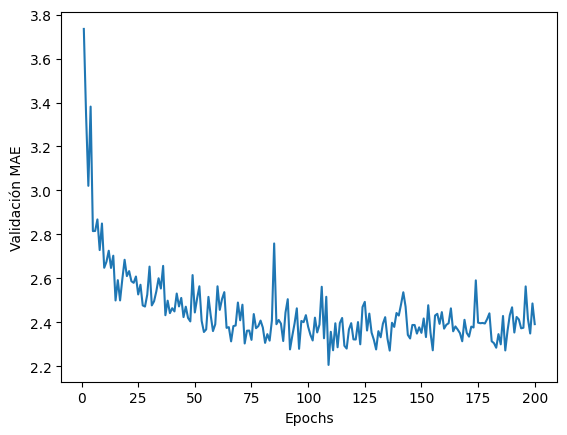

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_entrenamiento) + 1), average_mae_entrenamiento)
plt.xlabel('Epochs')
plt.ylabel('Validación MAE')
plt.show()


Puede ser un poco difícil extraer conocimiento de esta gráfica debido a los problemas de escala que presenta y a la alta varianza, así que podemos hacer lo siguiente:

* Omitir los primeros 10 puntos de los datos, que parecen mostrar una escala distinta al resto de la curva.
* Reemplazar cada punto con una media exponencial de los puntos anteriores, con el fin de obtener una curva más suave.

Probemos esta última opción:

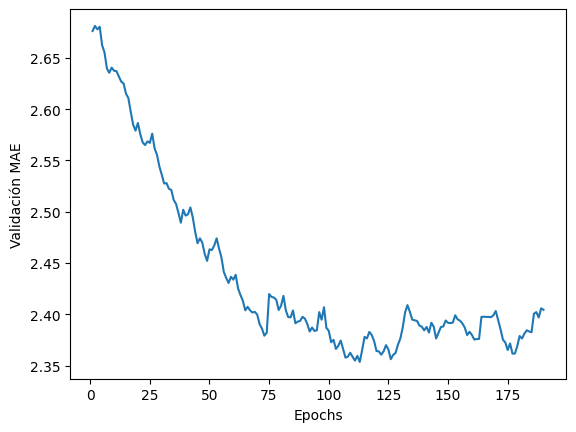

In [15]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_entrenamiento = smooth_curve(average_mae_entrenamiento[10:])

plt.plot(range(1, len(smooth_mae_entrenamiento) + 1), smooth_mae_entrenamiento)
plt.xlabel('Epochs')
plt.ylabel('Validación MAE')
plt.show()


De acuerdo con esta nueva gráfica, parece que el MAE de validación deja de mejorar tras 60-80 epochs (recuerda, cuanto menor valor, mejor), a partir de entonces empieza a haber sobreajuste.

Se podría considerar ajustar otros hiperparámetros del modelo (por ejemplo, el tamaño de las capas ocultas), y de analizar la mejor combinación, podemos entrenar una versión final del modelo sobre todos los datos de entrenamiento y medir el rendimiento sobre los datos de test:

In [16]:
# Entrenamos el modelo final con 80 épocas, ya que según la gráfica anterior parece un buen número
# Usamos para validación el mismo conjunto de test
modelo_final, history = train(X_train, y_train, X_test, y_test, num_epochs=80, batch_size=16)

**EJERCICIO**: reemplaza los FIXME para poder evaluar el modelo sobre el conjunto de test. Puedes ver la solución debajo.

In [ ]:
# Evaluación en test
modelo_final.FIXME() # poner el modelo en modo inferencia
with torch.FIXME():  # no registrar los gradientes
    preds = modelo_final(torch.from_numpy(FIXME)) # usa el conjunto de test
    preds_test = preds.squeeze().FIXME() # convierte a numpy array
test_mse = np.mean((preds_test - y_test)**2)
test_mae = np.mean(np.abs(preds_test - y_test))
print('\nResultados en test -> MSE: {:.4f}, MAE: {:.4f}'.format(test_mse, test_mae))

In [17]:
# Solución.
# Evaluación en test
modelo_final.eval()
with torch.no_grad():
    preds = modelo_final(torch.from_numpy(X_test))
    preds_test = preds.squeeze().numpy()
test_mse = np.mean((preds_test - y_test)**2)
test_mae = np.mean(np.abs(preds_test - y_test))
print('\nResultados en test -> MSE: {:.4f}, MAE: {:.4f}'.format(test_mse, test_mae))


Resultados en test -> MSE: 11.0331, MAE: 2.1895


Según el resultado en el conjunto de test, se sigue mostrando un error todavía muy alto, rondando los 2.200\$.


## 5. Conclusiones y referencias

* La regresión hace uso de funciones de pérdida distintas a la clasificación. La más común suele ser la *Mean Squared Error* (MSE).
* Además, las métricas de evaluación también suelen ser distintas, por ejemplo, *Mean Absolute Error* (MAE). El término "accuracy" aquí no tiene sentido.
* Cuando las características de los datos de entrada usan diferentes rangos, cada una de ellas ha de ser normalizada/estandarizada independientemente en la etapa de preprocesamiento.
* Si has usado estandarización, conserva la media y la desviación para aplicar la transformación en inferencia.
* Cuando tenemos pocos datos, usar K-validación cruzada puede ser un buen método para evaluar el modelo de forma más fiable sobre una configuración de hiper-parámetros.
* Cuando hay pocos datos, es preferible usar redes pequeñas con pocas capas (normalmente, 1 o 2) con el fin de evitar un sobreajuste exagerado.

Referencias:
* [Deep Learning with Python](https://deeplearningwithpython.io/chapters/), François Chollet, Matthew Watson